In [1]:
import os
from collections import OrderedDict

# What is different from V1:
I realized, that I can define losses directly to the embeddings. However I will probably have to pass different pairs of datasets for the different loss function - otherwise I will be trying to learn similarity on dissimilar things. I'll start with the "y" loss: The embedding for the head predicting "y" should be the same regardless of the experiment Id. I'm going to figure out a way to impose exactly that.

In [2]:
!cat bearing_fatigue_dataset/phm-ieee-2012-data-challenge-dataset/README.md

# PHM IEEE 2012 Data Challenge

This is a dataset that was used for the PHM IEEE 2012 Data Challenge. It used to be online at http://www.femto-st.fr/en/Research-departments/AS2M/Research-groups/PHM/IEEE-PHM-2012-Data-challenge.php, but isn't anymore.

The set contains a training set of 6 rolling bearings that were operated in three different conditions, and a testing set of 11 more. See the added PDF file for all the info of the challenge and the set.

## License

I don't know if there was any license to this, but always cite using below citation. There is a BibTeX entry in the PDF file.

## Citation

Nectoux, P., Gouriveau, R., Medjaher, K., Ramasso, E., Chebel-Morello, B., Zerhouni, N., … Varnier, C. (2012). PRONOSTIA : An experimental platform for bearings accelerated degradation tests. In IEEE International Conference on Prognostics and Health Management (pp. 1–8). Denver.



# TODO:
Read this: [Adversarial Discriminative Learning](http://openaccess.thecvf.com/content_cvpr_2017/papers/Tzeng_Adversarial_Discriminative_Domain_CVPR_2017_paper.pdf)
![image](img/AdversarialDiscriminativeDomainAdaptation.png)

# Load data:

In [3]:
import pandas as pd
import matplotlib.pyplot as pplot
import numpy as np
all_files = [f for f in os.listdir(os.path.join('bearing_fatigue_dataset')) if 'pickle' in f]
!ls bearing_fatigue_dataset/phm-ieee-2012-data-challenge-dataset/Learning_set/

load_from_disk = True;
if load_from_disk:
    def load_bearings_dataset(all_files = all_files):
        fnames = all_files
        exp_ids_tot = [];
        yrem_tot = [];
        sensor_values_tot = []

        for kk,fname in enumerate(fnames):
            p1 = pd.read_pickle("bearing_fatigue_dataset/%s"%fname)
            p1['abs_timestamp'] = (p1['h']*60+p1['m'])*60+p1['s']+p1['se-6']/1e6
            
            sensors = p1.groupby("block").apply(lambda x : [x['abs_timestamp'].mean(),np.vstack([x['h_acc'].values, x['v_acc'].values]).T])
            sens_val = np.dstack([v[1] for v in sensors.values])
            sensor_values = np.swapaxes(np.swapaxes(sens_val,0,-1),1,2).astype('float32')
            print(sensor_values.shape)

            yrem = np.vstack([v[0] for v in sensors.values]).astype('float32')
            yrem = np.abs(yrem - np.max(yrem))

            exp_id = np.hstack([kk for v in range(yrem.shape[0])])

            sensor_values_tot.append(sensor_values)
            exp_ids_tot.append(exp_id);
            yrem_tot.append(yrem)

            print(kk)

        yrem_tot = np.vstack(yrem_tot).flatten()
        eid = np.hstack(exp_ids_tot).flatten()
        X = np.vstack(sensor_values_tot)
        return yrem_tot, eid, X
    yrem_s_raw, eid, X = load_bearings_dataset()


Bearing1_1  Bearing1_2	Bearing2_1  Bearing2_2	Bearing3_1  Bearing3_2
(172, 2559, 2)
0
(1502, 2559, 2)
1
(1637, 2559, 2)
2
(515, 2559, 2)
3
(871, 2559, 2)
4
(1802, 2559, 2)
5
(2302, 2559, 2)
6
(1202, 2559, 2)
7
(1139, 2559, 2)
8
(2002, 2559, 2)
9
(572, 2559, 2)
10
(352, 2559, 2)
11
(797, 2559, 2)
12
(911, 2559, 2)
13
(612, 2559, 2)
14
(2803, 2559, 2)
15
(2302, 2559, 2)
16


In [4]:
# yrem = [];
# for ee in np.unique(eid):
#     yelapsed_ = np.cumsum(yrem_s_raw[eid == ee])
#     yrem_ = np.max(yelapsed_) - yelapsed_;
#     yrem.append(yrem_)
    
# yrem = np.hstack(yrem)
# gm = gamma_model(X[0:1]).sample(300)
# pplot.hist(gm[:,0,0],20)
normalization_factor_time = 25000;
yrem_norm = yrem_s_raw/normalization_factor_time;
#y>10000
#y[y>0.2] = 0.2
yrem_norm[yrem_norm<0.0001] = 0.0001
#pplot.plot(y,'-')
#yrem = y

eid_oh = np.zeros([eid.shape[0],np.max(eid) + 1])
for k in np.unique(eid):
    eid_oh[eid == k,k] = 1.;

#yrem_norm = yrem / np.std(yrem);

#training_set_mask = 
conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
inds_exp_source =  [4,6,8,15,  9,10,0,7,  2,11]

conds_flag_target = [0,0,0,   1, 1, 1,  2]
inds_exp_target  = [1,5,16,  12,13,14,  3]
#conds_flag_target = [0,0,0,   1,   2]
#inds_exp_target  = [1,5,16,  12,  3]





conds_flag = [*conds_flag_source, *conds_flag_target]
inds_experiments = [*inds_exp_source, *inds_exp_target]
exp_to_cond_dict = {k:v for k,v in zip(inds_experiments, conds_flag)}

loading_cond = [exp_to_cond_dict[k] for i,k in enumerate(np.argmax(eid_oh,1))]
loading_oh = np.zeros([eid_oh.shape[0],3])
for k in np.unique(loading_cond):
    loading_oh[loading_cond == k,k] = 1;


conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
inds_exp_source =  [4,6,8,15,  9,10,0,7,  2,11]

conds_flag_target = [0,0,0,   1,  2]
inds_exp_target  = [1,5,16,  12,  3]
    


# ###########################################################
# conds_flag_source =[0,0,0,0 ,0,  1,1,1 ,  2]
# inds_exp_source =  [4,6,8,15,16,  9,7,12,  11]

# conds_flag_target = [0,0 ,   1,  2]
# inds_exp_target   = [5,1,  13,  3]


###########################################################
# Less ambitious split:
# conds_flag_source = [1,1, 1,1]  #2,2]
# inds_exp_source =  [12,10,7,13]#  2,3]

# conds_flag_target = [   1]#,   2]
# inds_exp_target  = [9]#   11]


inds_experiments = [*inds_exp_source, *inds_exp_target]

#############################################################
#Remove unused experiments:

ids_filter = [i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_experiments]

In [5]:
###################################################
# 
# for the moment I do not try to adapt domains with info pertaining to the loading conditions.
dat_vals = [v_[ids_filter] for v_ in [X, yrem_norm,eid_oh, loading_oh]]
eid_oh_subs = dat_vals[2];

#dat_vals
## Ballance classes/experiments by resampling:
eid_vals = np.argmax(eid_oh_subs,1);
exp_vals_unique = np.unique(eid_vals)

exp_vals_counts = []
for e in exp_vals_unique:
    exp_vals_counts.append(np.sum(eid == e))

exp_vals_counts = np.array(exp_vals_counts)
resample_factors = [int(np.max(exp_vals_counts)/ee) for ee in exp_vals_counts]
resampling_dict = OrderedDict([(k,v) for k,v in zip(exp_vals_unique,resample_factors)])

#resampling_dict
# Change dat_vals by resampling experiments:
dat_vals_resampled = [[],[],[],[]];
for k,v in zip(resampling_dict.keys(), resampling_dict.values()):
    ids_this_exp = dat_vals[2]==k
    dat_vals_resampled[0].append(np.repeat(dat_vals[0][np.argmax(eid_oh_subs,1)==k],v,0))
    dat_vals_resampled[1].append(np.repeat(dat_vals[1][np.argmax(eid_oh_subs,1)==k],v,0))
    dat_vals_resampled[2].append(np.repeat(dat_vals[2][np.argmax(eid_oh_subs,1)==k],v,0))
    dat_vals_resampled[3].append(np.repeat(dat_vals[3][np.argmax(eid_oh_subs,1)==k],v,0))

vv = dat_vals_resampled[0]
dat_vals_resampled = [np.concatenate(vv, axis = 0) for vv in dat_vals_resampled]
eid_oh_subs = dat_vals_resampled[2];

def get_source_or_target(x_,f_):
    inds = [i for i,k in enumerate(np.argmax(eid_oh_subs,1)) if k in f_]
    return x_[inds]


#get_source_or_target  = lambda x_,f_ : x_[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in f_]]
X_source_experiments, yrem_norm_source, eid_oh_source, cond_oh_source  = [get_source_or_target(v_, inds_exp_source)
                                                                          for v_ in dat_vals_resampled]

X_target_experiments,yrem_norm_target, eid_oh_target, cond_oh_target  = [get_source_or_target(v_, inds_exp_target) 
                                                                          for v_ in  dat_vals_resampled]


### Use the top "source" domain. I need to generalize to "target" and show that embeddings 
# are indeed similar without the network ever seeing the "target" domain.

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, d_train, d_test, c_train, c_test = train_test_split(X_source_experiments, yrem_norm_source, eid_oh_source, cond_oh_source, stratify = eid_oh_source)


## Adversarial learning on the FEMTO accelerated fatigue bearing dataset
The dataset is associated with a challenge for the PHM conference on 2012.
The motivation of this work is to investigate if and when adversarial learning on raw time-series performs well. The hypotheses of this work are the following:

* **Dilated DenseNets** are flexible enough to work with raw time-series (this is not an established fact in SHM applications)
* Adversarial learning can be used to normalize implicitly for **domain shifts** without manual intervention. 

The following need to be performed:
* Preprocessing (making the dataset appropriate for training with the adversarial densenet - domain labels etc)
* Train/test splitting for the raw accelerometer time-series
* write the optimization loop
* run prelim. experiments - hopefully something will fit. 
* write code for performing 1-vs-rest experiments to test generalization.

In [6]:
import tensorflow as tf
#tf.enable_eager_execution()

import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as pplot
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout

import os

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow_probability as tfp
tfd  = tfp.distributions


config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)
#tf.keras.backend.set_session(sess)
#from tensorflow.math import confusion_matrix

In [7]:
tf.__version__

'2.1.0'

In [8]:
# from src.dilated_densenet_adversarial import make_model, make_densenet_parametrization_dictionary

# def calc_receptive_field(Nd, Nf, conv_type = "causal"):
#     "returns the number of input taps each layer in a dilated caysal conv stack sees."
#     if conv_type == "causal":
#         corr = [0]+[1]*(len(Nd)-1)#correction for double counted neurons.
    
#     return np.cumsum([(nf_) * (nd_) - (nd_-1) - c for nf_, nd_ ,c in zip(Nf, Nd, corr)])  #- (len(Nd)) + 1


# from src.util import plot_confusion_matrix
# from src.experiments_utils import *

# ndn = 4
# nkernel = 4;
# ndn2 = 6
# ndomain = 17;

# experiment_parametrization = {
#     'dilation_rates_dn1': [1,4,8,16,32,64,128,256,512,8,16,32,64,128,512][0:ndn],#,4,8,16,32],
#     'kernel_sizes_dn1' :  [nkernel] * ndn,#,5,5],
#     'nfilters_dn1' :  [50]*ndn,
#     'dilation_rates_dn2' : [2]*ndn2,
#     'kernel_sizes_dn2' : [5]*ndn2,
#     'nfilters_dn2': [10]*ndn2
# }

# make_network_description_experiments_A(**experiment_parametrization)
# model_json = make_network_json_experiments_A(**experiment_parametrization)
# #

# model_json['classifier']['network_layers'][0]['params']['units'] = 640
# model_json["densenet_1d"]["network_layers"][0]["params"]["Variational"] = False
# model_json["densenet_1d"]["network_layers"][0]['params']["dropout_after_composite"] = 0.1
# model_json["densenet_1d"]["network_layers"] = [
#     model_json["densenet_1d"]["network_layers"][0],model_json["densenet_1d"]["network_layers"][-1]
# ]
# model_json['inputs'][0]['shape'] = (2559,2)
# model_json['domain_classifier']['network_layers'][-1]['params']['units'] = ndomain
# # Make the model act as a regressor:
# model_json['classifier']['network_layers'][-1]['params']['units'] = 1
# Nf = model_json['densenet_1d']['network_layers'][0]['params']['kernel_sizes']
# Nd = model_json['densenet_1d']['network_layers'][0]['params']['dilation_rates']
# #model_json['densenet_1d']['network_layers']
# #single_DN_stack_rf = calc_receptive_field(Nd,Nf)
# #single_DN_stack_rf * len(Nf)
# calc_receptive_field(Nd,Nf) * len(Nf)


In [9]:

def make_conv_input_head(nfilts = 64, nfilts2 = 128, ksize = 2):
#     nfilts = 64;
#     nfilts2 = 128
#     ksize = 2;

    xin = tf.keras.Input(shape = (None, 2) , name = "timeseries_input"); 

    yout = Conv1D(kernel_size = 1 , filters = 100, strides = 1, use_bias = False)(xin)
    yout = Conv1D(kernel_size=ksize,filters = nfilts, strides=2, use_bias= False)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts,use_bias= False)(yout)
    yout = Dropout(rate = 0.2)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts,activation  = "relu",use_bias= True)(yout)
    yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

    yout = Conv1D(kernel_size=ksize, strides=2, filters = nfilts2,use_bias= False)(yout)
    yout = Dropout(rate = 0.2)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= False)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,activation  = "relu",use_bias= False)(yout)
    yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

    yout = keras.layers.GlobalAveragePooling1D()(yout)

    mconv = keras.Model(inputs = xin, outputs = yout)
    # mconv.summary()
    return mconv

    

In [10]:
# I need to transform the model to 
## Make the creation of discriminators between domains automatic:

#base_model = make_model(model_json)
base_model = make_conv_input_head();
get_global_pool_layer = lambda mm : mm.get_layer([l.name for l in mm.layers if 'global_average' in l.name][0])


In [11]:

NParams = 1;
NSamples = 10;

y_distr_in = Dense(NParams*2, use_bias = False, activation = lambda x : tf.nn.softplus(x))(base_model.output);
gamma_out = tfp.layers.DistributionLambda(make_distribution_fn = lambda t: tfd.Gamma(concentration = t[:,0:NParams], rate = t[:,NParams:2*NParams] ), convert_to_tensor_fn= lambda s : s.sample(NSamples))(y_distr_in);

gamma_model = Model(inputs = base_model.input, outputs = gamma_out)

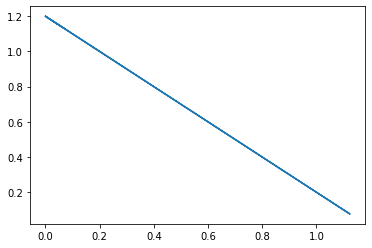

In [12]:
pplot.plot(yrem_norm,(1.2 - yrem_norm))

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm = 1)

gamma_nll_loss = lambda y_, py_ : -py_.log_prob(y_) * (1.2 - y_)**2
gamma_model.compile(loss = gamma_nll_loss, optimizer=opt)
h = gamma_model.fit(x_train,y_train, epochs=100, validation_data= [x_test,y_test])
# for kk in range(150, 199):
#     Xt = tf.Variable(X[kk:kk+1])
#     yt = tf.Variable(y[kk:kk+1])
#     gamma_nll_loss = lambda y_, py_ : -py_.log_prob(y_)

#     with tf.GradientTape() as tape:
#         loss = gamma_nll_loss(yt,gamma_model(Xt))
#         g = tape.gradient(loss, gamma_model.weights)

#         #gamma_model.fit(X, y, batch_size=100, validation_split=0.5)
#     print(kk, np.any([np.any(np.isnan(g_)) for g_ in g]))
#     if np.any([np.any(np.isnan(g_)) for g_ in g]):

#         break

Train on 17657 samples, validate on 5886 samples
Epoch 1/100
17657/17657 [==============================] - 6s 347us/sample - loss: -0.8519 - val_loss: -0.9428
Epoch 2/100
17657/17657 [==============================] - 4s 213us/sample - loss: -1.0909 - val_loss: -0.9354
Epoch 3/100
17657/17657 [==============================] - 4s 215us/sample - loss: -1.2374 - val_loss: -1.3444
Epoch 4/100
17657/17657 [==============================] - 4s 215us/sample - loss: -1.3508 - val_loss: -1.1198
Epoch 5/100
17657/17657 [==============================] - 4s 217us/sample - loss: -1.3993 - val_loss: -1.4115
Epoch 6/100
17657/17657 [==============================] - 4s 218us/sample - loss: -1.4745 - val_loss: -1.5740
Epoch 7/100
17657/17657 [==============================] - 4s 216us/sample - loss: -1.5317 - val_loss: -1.5220
Epoch 8/100
17657/17657 [==============================] - 4s 217us/sample - loss: -1.5420 - val_loss: -1.6078
Epoch 9/100
17657/17657 [==============================] - 4s 2

Epoch 74/100
17657/17657 [==============================] - 4s 214us/sample - loss: -2.3536 - val_loss: -2.2272
Epoch 75/100
17657/17657 [==============================] - 4s 219us/sample - loss: -2.3373 - val_loss: -2.4083
Epoch 76/100
17657/17657 [==============================] - 4s 225us/sample - loss: -2.3657 - val_loss: -2.3619
Epoch 77/100
17657/17657 [==============================] - 4s 224us/sample - loss: -2.3719 - val_loss: -2.3421
Epoch 78/100
17657/17657 [==============================] - 4s 218us/sample - loss: -2.3581 - val_loss: -2.3656
Epoch 79/100
17657/17657 [==============================] - 4s 214us/sample - loss: -2.3837 - val_loss: -2.1025
Epoch 80/100
17657/17657 [==============================] - 4s 226us/sample - loss: -2.3750 - val_loss: -2.4420
Epoch 81/100
17657/17657 [==============================] - 4s 213us/sample - loss: -2.3976 - val_loss: -2.1632
Epoch 82/100
17657/17657 [==============================] - 4s 211us/sample - loss: -2.3699 - val_loss: 

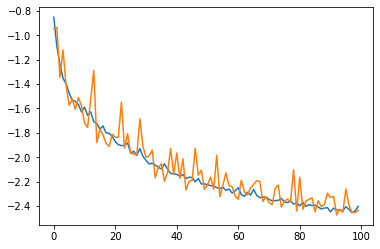

In [14]:
pplot.plot(h.history['loss'])
pplot.plot(h.history['val_loss'])

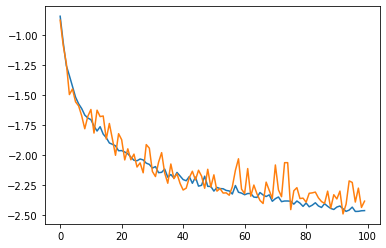

In [186]:
pplot.plot(h.history['loss'])
pplot.plot(h.history['val_loss'])

In [15]:
times=np.linspace(0,1.5,50);
res = []
for kstart in range(0, X.shape[0],200):
    
    kend = kstart + 200
    res.append(gamma_model(X_target_experiments[kstart:kend]).prob(times))
res_tot = np.vstack(res)


In [16]:
def estimation_for_experiment(exp_number):
    None
#pplot.plot(res_tot[0:1000].T)
#pplot.pcolor(res_tot[0:1400].T)
res_tot[np.argmax(eid_oh_target,1) == 1]

array([[0.0000000e+00, 1.3012793e-22, 5.7877281e-10, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.5311648e-09, 1.4644673e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 7.3145249e-12, 5.1325289e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 3.8150562e+01, 7.0374352e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 4.2840851e+01, 1.7284515e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 7.5380411e+00, 1.0280247e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [17]:
#pplot.plot(y)
#_.quantile([0.1,0.5,0.9])
X_target_experiments.shape, yrem_norm_target.shape, res_tot.shape

((10572, 2559, 2), (10572,), (10572, 50))

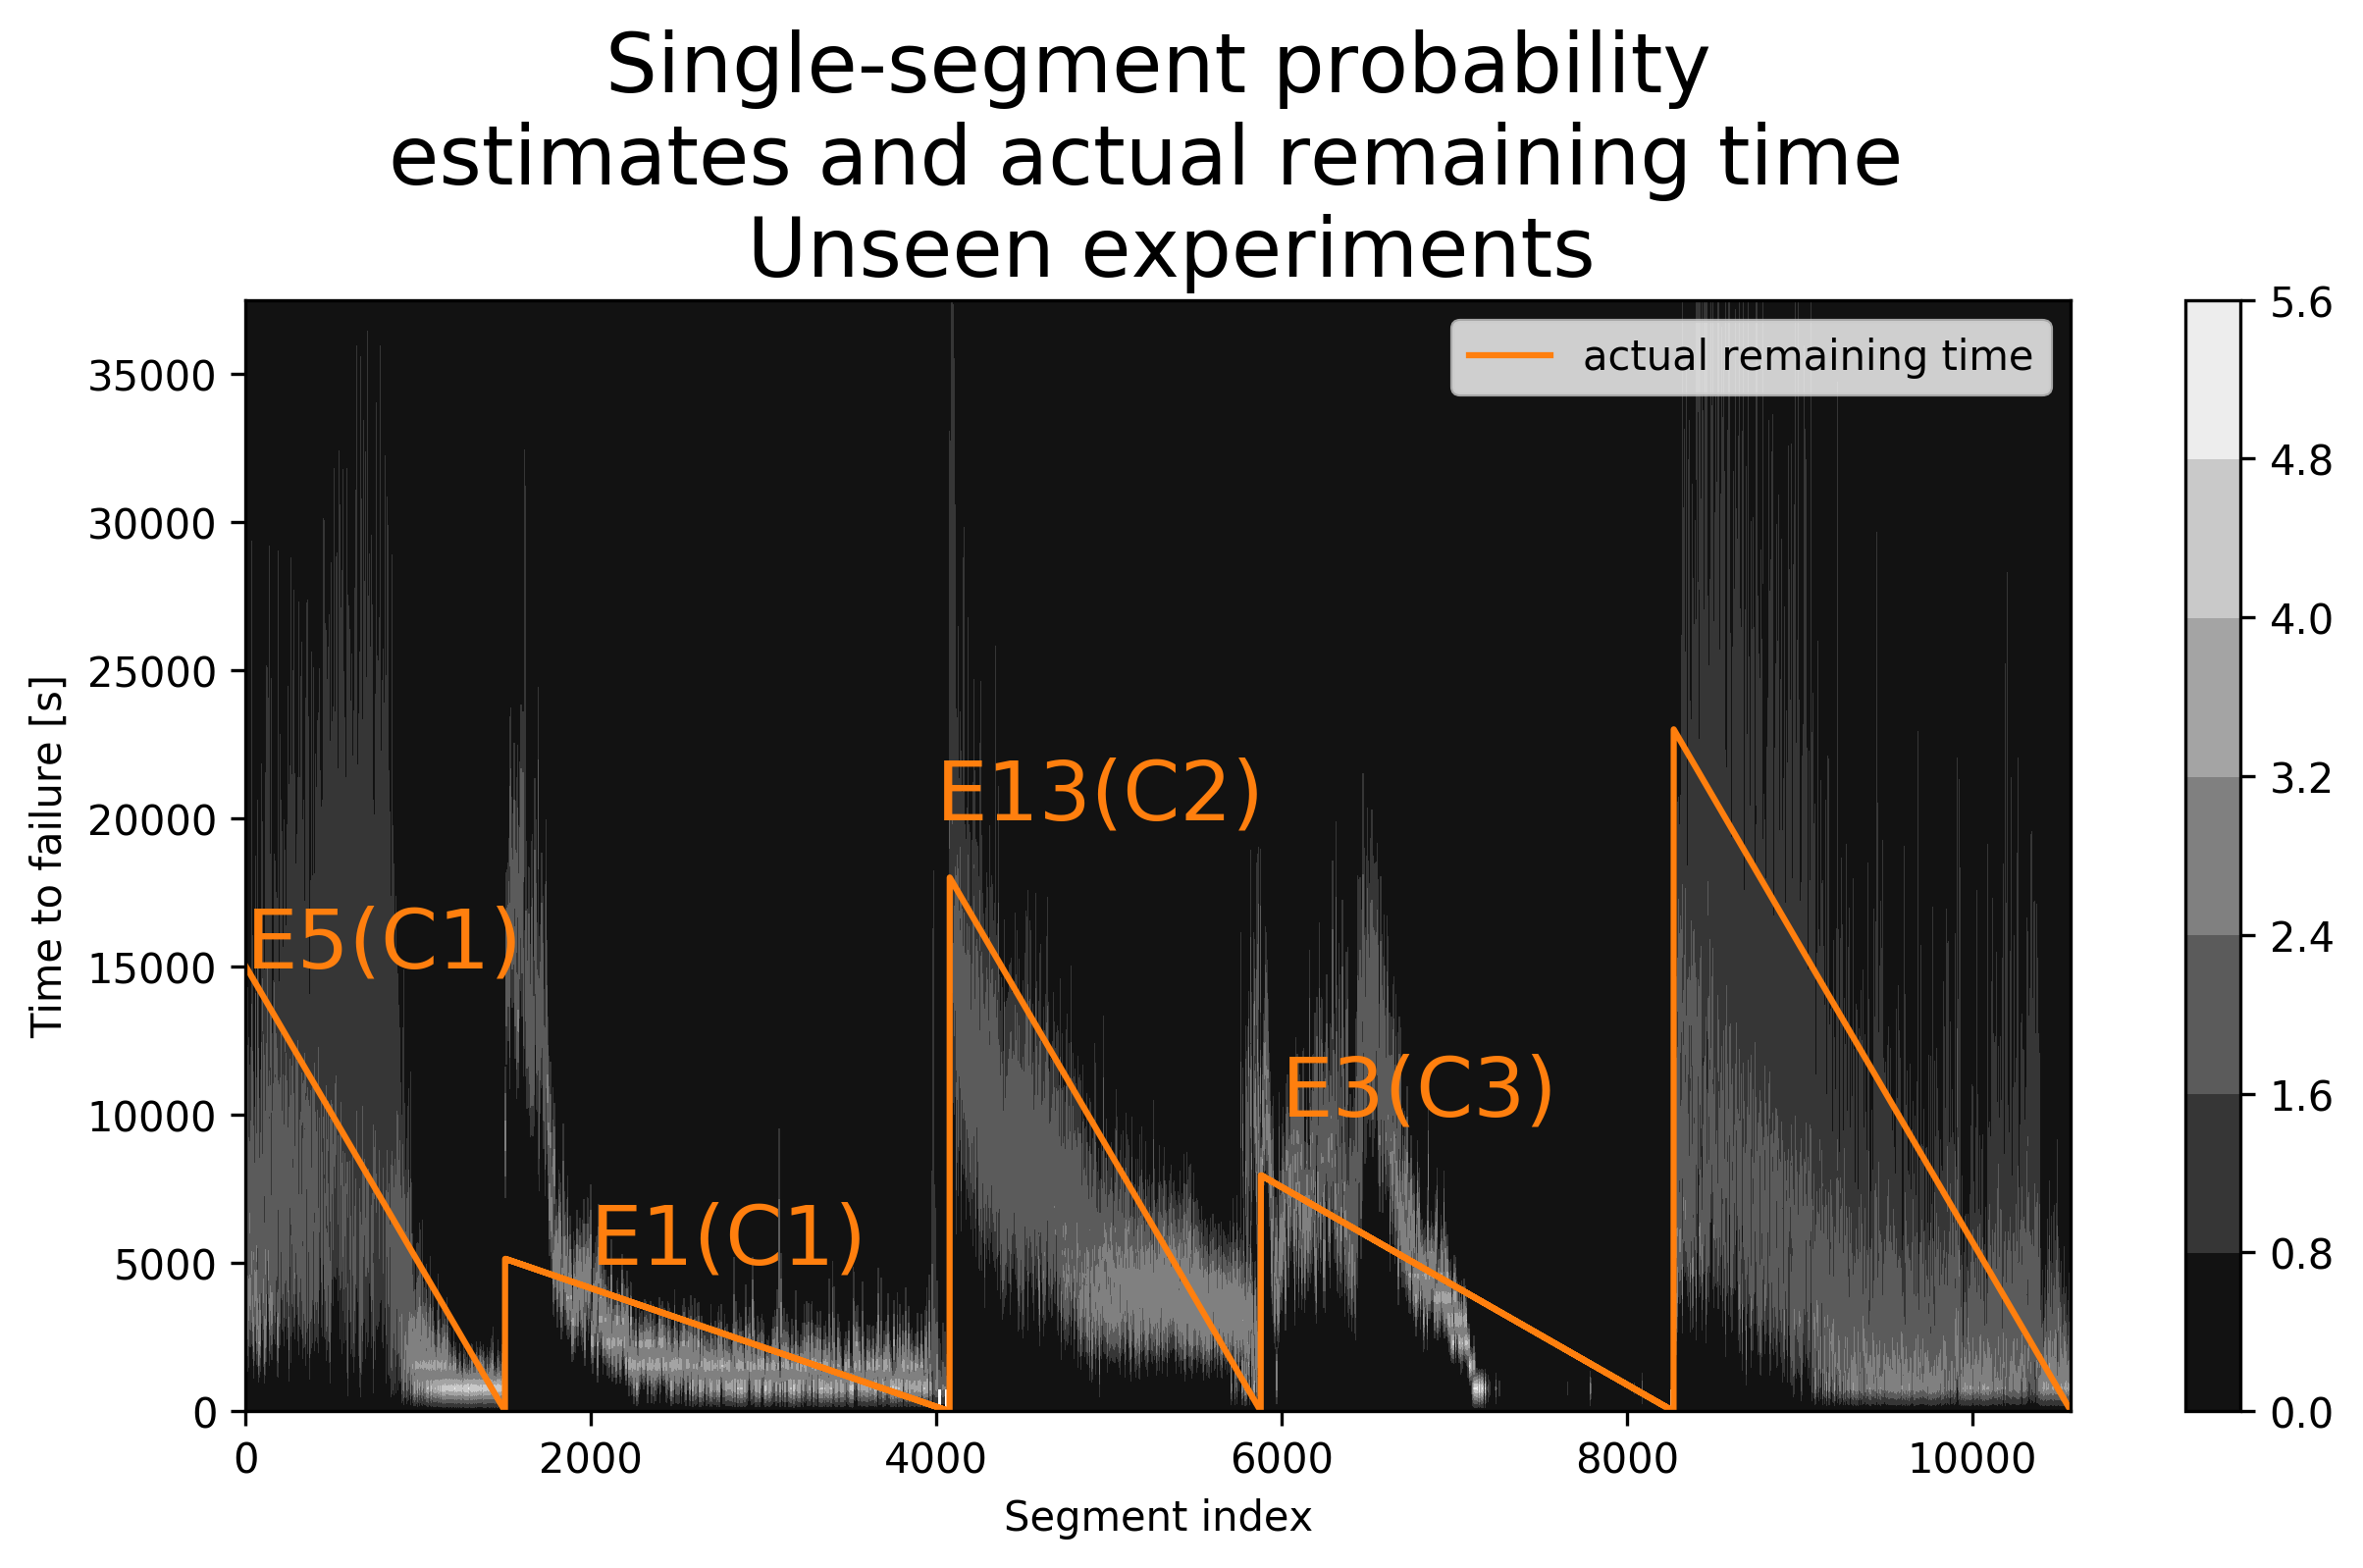

In [18]:
skip_vals = 1;
pplot.figure(figsize = (10,5), dpi = 300)
res_plt = res_tot[::skip_vals,...].T;
yy_ = times * normalization_factor_time
xx_ = np.array([kk for kk in range(res_plt.shape[1])])
[xx__, yy__] = np.meshgrid(xx_, yy_);

pplot.contourf(xx__,yy__,res_plt**0.4, cmap = "gray")
pplot.xlabel("Segment index")
pplot.ylabel("Time to failure [s]")

pplot.plot(yrem_norm_target[::skip_vals]*normalization_factor_time,'C1-', label = "actual remaining time")
pplot.legend()
pplot.title("Single-segment probability\nestimates and actual remaining time \n Unseen experiments", fontsize = 20)
pplot.colorbar()
#pplot.savefig("gamma_distr_out_predictions_noadv.png")
pplot.text(0.0,15000.0,"E5(C1)", fontdict={"color" : "C1", "fontsize" : 20})
pplot.text(2000.0,5000.0,"E1(C1)", fontdict={"color" : "C1", "fontsize" : 20})
pplot.text(4000,20000,"E13(C2)", fontdict={"color" : "C1", "fontsize" : 20})
pplot.text(6000,10000.0,"E3(C3)", fontdict={"color" : "C1", "fontsize" : 20})
pplot.savefig("gamma_distr_out_predictions_noadv_morex.png")



# Adverarial regularization
I'm adding heads to the network so that the predictive task is learned separately from the bias of the experiments. The bias should not be used for prediction directly but implicitly. 

In [195]:
## Automatic creation of discriminators between domains:
mconv_adv = make_conv_input_head();
base_model_adv = mconv_adv;
get_global_pool_layer = lambda mm : mm.get_layer([l.name for l in mm.layers if 'global_average' in l.name][0])
from src.dilated_densenet_adversarial import GradReverse

# The definition of the domains:
#d_y = {'name' : 'y' , 'output_head_size' : 1, "loss" : lambda y,yhat : tf.reduce_mean(tf.abs(y-yhat))}
d_y = {"name" : "y" , "output_params" : {"size": 1, "isprob" : True ,"prob_params" : {"distribution" : "gamma" }}, "loss"  : lambda y_, py_ : gamma_nll_loss(y_, py_)}
d_d = {'name' : 'd' , 'output_params' : {"size" : 17, "isprob" : False}, "loss" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat)}
d_l = {'name' : 'l' , 'output_params' : {"size" : 3 , "isprob" : False} , "loss" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat)}

#domains = [d_a,d_b,d_c]

# Define domain relations:
#a_i sub c
#c sub b

DDA_input_layer = get_global_pool_layer(base_model_adv)

def make_sep_model_heads_fcn(features_input_layer, head_params):
    """
    Returns 4 network heads, their embedding layers, 
    and their respective losses for a discriminative domain adversarial network.
    """
    
    d1_name, d1_out, d1_loss = [head_params[0][hval] for hval in ['name' , 'output_params' , 'loss']]
    d2_name, d2_out, d2_loss = [head_params[1][hval] for hval in ['name' , 'output_params' , 'loss']]
    
    Ename_d1d2 = "P_%s_C_%s"%(d1_name,d2_name);
    Ename_d2d1 = "P_%s_C_%s"%(d2_name,d1_name);
    
    # The embeddings that learn @ each domain separately:
    Emb_P_d1_C_d2 = keras.Sequential([
        keras.layers.Dense(100,activation = "relu") ,
        keras.layers.Dense(100, use_bias = False),
        Dropout(rate = 0.2),
    ], name = Ename_d1d2)(features_input_layer.output)
    
    Emb_P_d2_C_d1 = keras.Sequential([
        keras.layers.Dense(100,activation = "relu") ,
        keras.layers.Dense(100, use_bias = False),
        Dropout(rate = 0.2),
    ],name =Ename_d2d1)(features_input_layer.output)
    
    def make_class_head(emb_in, out_params , name):
        """
        emb_in   : the input tensor to the stack
        out_size : the output of the stack (for classifier it is the number of classes. For regressor it is "1".)
        name     : the name of the output. The name contains the input embedding, and whether it is a critic or a predictor.
        """
        
        domain_critic_or_predictor    = keras.Sequential(name = name)

        # if this is a "critic" head a grad reverse layer is added:
        if name[-6:] == "critic":
            domain_critic_or_predictor.add(GradReverse());
        
        if not out_params['isprob']:
            domain_critic_or_predictor.add(Dense(100, activation = 'relu'))
            domain_critic_or_predictor.add(Dense(100, use_bias = False))
            domain_critic_or_predictor.add(Dropout(rate = 0.2))
            domain_critic_or_predictor.add(Dense(out_params['size']));
            
        if out_params['isprob']:
            # Build a probabilistic layer for this output
            NParams = 1;
            NSamples = 10;
            
            domain_critic_or_predictor.add(
                Dense(NParams*2, use_bias = False, activation = lambda x : tf.nn.softplus(x)+0.0001)
            )
            domain_critic_or_predictor.add(
                tfp.layers.DistributionLambda(
                    make_distribution_fn = lambda t: tfd.Gamma(concentration = t[:,0:NParams], rate = t[:,NParams:2*NParams] ),
                    convert_to_tensor_fn= lambda s : s.sample(NSamples))
            )

            

        return domain_critic_or_predictor(emb_in)
    
    # Construct the critic and the predictor for each domain:
    Pd1Cd2_d2_critic , Pd1Cd2_d1_predictor = [make_class_head(Emb_P_d1_C_d2 , out_size ,"%s_%s"%(Ename_d1d2, head_)) 
                                              for out_size, head_ in zip([d2_out,d1_out], ["critic", "predictor"])];
    
        
    Pd2Cd1_d1_critic , Pd1Cd2_d2_predictor = [make_class_head( Emb_P_d2_C_d1 ,out_size, "%s_%s"%(Ename_d2d1, head_)) 
                                              for out_size,head_ in zip([d1_out,d2_out], ["critic", "predictor"])];
    
    
    
    losses = OrderedDict()
    
    losses.update({"%s_%s"%(Ename_d1d2, "critic")    : d2_loss})
    losses.update({ "%s_%s"%(Ename_d1d2, "predictor") : d1_loss})
    losses.update({ "%s_%s"%(Ename_d2d1, "critic") : d1_loss})
    losses.update({ "%s_%s"%(Ename_d2d1, "predictor") : d2_loss})
    
    outputs = [Pd1Cd2_d2_critic , Pd1Cd2_d1_predictor , Pd2Cd1_d1_critic , Pd1Cd2_d2_predictor]
    
    outputs_expected_label  = [d2_name, d1_name, d1_name, d2_name];
    
    return outputs, losses, outputs_expected_label

outputs_ab = make_sep_model_heads_fcn(DDA_input_layer, [d_y, d_d])
outputs_ac = [[],{},[]];outputs_bc = [[],{},[]];
outputs_ac = make_sep_model_heads_fcn(DDA_input_layer, [d_y, d_l])
#outputs_bc = make_sep_model_heads_fcn(DDA_input_layer, [d_d, d_l])

all_output_domains = [*outputs_ab[2],          *outputs_ac[2]         ,*outputs_bc[2]]
all_outputs        = [*outputs_ab[0],          *outputs_ac[0]         ,*outputs_bc[0]]
all_loss_names     = [*outputs_ab[1].keys(),   *outputs_ac[1].keys(),  *outputs_bc[1].keys()]
all_loss_functions = [*outputs_ab[1].values(), *outputs_ac[1].values(),*outputs_bc[1].values()]

losses = OrderedDict({k:v for k,v in zip(all_loss_names, all_loss_functions)})

# def loss_fcn(yreal,yhat):
#     """
#     A discrepancy loss
#     """
#     W= tf.matmul(yhat[:,0:-17], yhat[:,-17:], transpose_a=True, transpose_b=False)
#     Vmeans = tf.transpose(tf.matmul(W , yhat[:,-17:], transpose_a = False, transpose_b = True))
#     loss_mean = tf.reduce_sum(tf.square(yhat[:,0:-17] - Vmeans), axis=0)
#     loss_norm = tf.reduce_sum(tf.abs(tf.reduce_mean(tf.square(yhat[:,0:-17]), axis = 1)-1), axis = 0) # approximately the squared norm of each row should be close to 1.
#     return (loss_mean + loss_norm) * 0.0001

# def loss_fcn_pred(y_, py_):
#     # gamma_nll_loss = lambda y_, py_ : -py_.log_prob(y_)
#     return -py_.log_prob(y_)

# Training the adversarial model


In [196]:
epochs = 200; #training_parameters["nepochs"]

batchsize =600;
if (tf.__version__ == '2.1.0'):
    confusion_matrix = tf.compat.v1.math.confusion_matrix
else:
    from tensorflow.math import confusion_matrix
    
import tensorflow.keras as keras
from tensorflow.keras import layers 

LRATE_MIN = 0.0001;
LRATE_MAX = 0.001;
BURNIN_EPOCHS = 1;

model_filepath = "discadv_models/model_test_closs0.1.h5"

closs = 0.01;

aux_loss_factor = 0.5;

def _loss_from_name(n_):
    if 'P_y_C_d_predictor' in n_:
        print("setting loss to 1 for %s"%n_)
        return 1.;
    if 'P_y_C_d_critic' in n_:
        return closs;
    
    if 'P_y_C_l_predictor' in n_:
        return 1. * aux_loss_factor;
    if 'P_y_C_l_critic' in n_:
        return closs * aux_loss_factor
    
#     if 'P_d_C_y_predictor' in n_:
#         return 1. * aux_loss_factor;
#     if 'P_d_C_y_critic' in n_:
#         return closs * aux_loss_factor;
    
   
#     if 'P_l_C_y_predictor' in n_:
#         return aux_loss_factor;
#     if 'P_l_C_y_critic' in n_:
#         return closs * aux_loss_factor;
    
    
#     if 'P_l_C_d_predictor' in n_:
#         return 0
#     if 'P_l_C_d_critic' in n_:
#         return 0

#     if 'P_d_C_l_predictor' in n_:
#         return 0
#     if 'P_d_C_l_critic' in n_:
#         return 0

    return 0;
    print(n_)

def _loss_noadv(n_):
    if 'P_y_C_d_predictor' != n_:
        return closs;
    else:
        return 1.
    

    
#dict_output_domain_name_to_label = {"d" :  ,"y" : "y", ""}
def data_to_input_dict(X = None,y = None ,d = None,l = None):
    """
    X: the input time-series
    y: the prediction of time to failure
    d: the experiment ID
    l: the loading conditions "domain"
    """
    kwargs = {"X" : X, "y" : y, "d":d,"l" : l};
    
    data_in_dict  = {"timeseries_input": X}
    
    # The ordering must be correct (it is, but could it break down?). 
    # Since domains don't have the same losses or values errors will be thrown otherwise.
    #output_layers_names = [l.name for l in disc_adv.layers if "critic" in l.name or "predictor" in l.name];
    data_out_dict = {k:kwargs[v] for k,v in zip(all_loss_names ,all_output_domains)}
    return data_in_dict, data_out_dict
    
loss_weight_dict = {k: _loss_from_name(k) for k in losses.keys() }
#loss_weight_dict = {k: _loss_noadv(k) for k in losses.keys() }

monitor_loss = 'val_P_y_C_d_predictor_loss'

es = keras.callbacks.EarlyStopping(monitor=monitor_loss , mode='min', verbose=1, patience=10, restore_best_weights = True)
checkpointing = keras.callbacks.ModelCheckpoint(model_filepath , monitor = monitor_loss, mode = 'min', save_best_only = True)
model_opt = keras.optimizers.Adam(learning_rate=0.0);
#model_opt = tf.keras.optimizers.Adam(learning_rate=0.0, clipnorm = 1)

target_predictions = [];
        
class plot_fit(tf.keras.callbacks.Callback):
    def __init__(self):
        self.y_output_index = [i for i,l in enumerate(disc_adv.outputs) if 'P_y_C_d_predictor' in l.name][0]
        None
        
    def on_epoch_end(self,epoch, logs = None):
        print("supposedly plotting...")
        return None
        if (epoch+1) % 2 == 0:
            
            yhat = disc_adv.predict(x_train, batch_size = batchsize)
            pplot.cla()
            
            pplot.plot(yhat[self.y_output_index], y_train,'.')
            pplot.show()
            
        yhat_target = disc_adv.predict(X_target_experiments, batch_size = batchsize )
        target_predictions.append(yhat_target[2])
        
class BurnIn(tf.keras.callbacks.Callback):
    def __init__(self, burnin_epochs = None, lrate_max = LRATE_MAX):
        self.learning_rate = lrate_max
        self.burnin_epochs = burnin_epochs
        
    def on_epoch_end(self,epoch, logs = None):
        if epoch <= self.burnin_epochs:
            de = epoch/self.burnin_epochs
            lrate = de * self.learning_rate
            print("-"*10)
            if lrate < LRATE_MIN:
                model_opt.learning_rate = LRATE_MIN
            else:
                model_opt.learning_rate = de * self.learning_rate
                print("----- setting learning rate to %2.4f"%(de * self.learning_rate))
            print(model_opt.learning_rate)
            print("-"*10)


loss_fcn = losses

disc_adv = Model(inputs = mconv_adv.input, outputs = all_outputs)
# GOAL: Maximize the loss of the domain critic while maximizing the actual predictor.
# useful discriminator:
disc_adv.compile(optimizer =  model_opt,
              loss =loss_fcn,
              loss_weights = loss_weight_dict)

train_in, train_out = data_to_input_dict(X = x_train, y = y_train, d = d_train, l = c_train)
test_in, test_out = data_to_input_dict(X = x_test, y = y_test, d = d_test, l = c_test)

burnin = BurnIn(burnin_epochs = BURNIN_EPOCHS, lrate_max = LRATE_MAX)
history_d = disc_adv.fit(train_in, train_out, epochs=epochs,
                     batch_size=batchsize,
                      validation_data = [test_in, test_out],# "Rc_output" :  RemCTest}],
                     callbacks=[es, burnin, plot_fit(), checkpointing])#, Top3AccStrong()])#, InspectActivations()]);#, Top3AccStrong()])


setting loss to 1 for P_y_C_d_predictor
Train on 17657 samples, validate on 5886 samples
Epoch 1/200
custom grad
custom grad
custom grad
custom grad
custom grad
custom grad
custom grad
custom grad
17400/17657 [============================>.] - ETA: 0s - loss: -0.1947 - P_y_C_d_critic_loss: 2.8355 - P_y_C_d_predictor_loss: -0.1672 - P_d_C_y_critic_loss: -0.1173 - P_d_C_y_predictor_loss: 2.8294 - P_y_C_l_critic_loss: 1.0932 - P_y_C_l_predictor_loss: -0.1226 - P_l_C_y_critic_loss: -0.0978 - P_l_C_y_predictor_loss: 1.0976----------
<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=1e-04>
----------
supposedly plotting...
17657/17657 [==============================] - 6s 368us/sample - loss: -0.1940 - P_y_C_d_critic_loss: 2.8355 - P_y_C_d_predictor_loss: -0.1662 - P_d_C_y_critic_loss: -0.1162 - P_d_C_y_predictor_loss: 2.8295 - P_y_C_l_critic_loss: 1.0932 - P_y_C_l_predictor_loss: -0.1215 - P_l_C_y_critic_loss: -0.0966 - P_l_C_y_predictor_loss: 1.0975 - val_loss: -0.1778 - va

Epoch 9/200
17657/17657 [==============================] - 3s 149us/sample - loss: -1.6556 - P_y_C_d_critic_loss: 1.9601 - P_y_C_d_predictor_loss: -1.1248 - P_d_C_y_critic_loss: -0.3836 - P_d_C_y_predictor_loss: 2.8155 - P_y_C_l_critic_loss: 0.9070 - P_y_C_l_predictor_loss: -1.1138 - P_l_C_y_critic_loss: 0.0917 - P_l_C_y_predictor_loss: 1.1811 - val_loss: -1.7888 - val_P_y_C_d_critic_loss: 1.8497 - val_P_y_C_d_predictor_loss: -1.2159 - val_P_d_C_y_critic_loss: -0.4003 - val_P_d_C_y_predictor_loss: 2.8054 - val_P_y_C_l_critic_loss: 0.8318 - val_P_y_C_l_predictor_loss: -1.1954 - val_P_l_C_y_critic_loss: 0.0795 - val_P_l_C_y_predictor_loss: 1.1576
Epoch 10/200
17657/17657 [==============================] - 3s 151us/sample - loss: -1.7384 - P_y_C_d_critic_loss: 1.9652 - P_y_C_d_predictor_loss: -1.1788 - P_d_C_y_critic_loss: -0.3870 - P_d_C_y_predictor_loss: 2.8115 - P_y_C_l_critic_loss: 0.8506 - P_y_C_l_predictor_loss: -1.1741 - P_l_C_y_critic_loss: 0.1162 - P_l_C_y_predictor_loss: 1.1697 

17657/17657 [==============================] - 2s 141us/sample - loss: -2.5274 - P_y_C_d_critic_loss: 1.1188 - P_y_C_d_predictor_loss: -1.6987 - P_d_C_y_critic_loss: -0.2120 - P_d_C_y_predictor_loss: 2.8749 - P_y_C_l_critic_loss: 0.6861 - P_y_C_l_predictor_loss: -1.6929 - P_l_C_y_critic_loss: 0.6028 - P_l_C_y_predictor_loss: 1.4142 - val_loss: -2.3186 - val_P_y_C_d_critic_loss: 0.9354 - val_P_y_C_d_predictor_loss: -1.5589 - val_P_d_C_y_critic_loss: -0.2329 - val_P_d_C_y_predictor_loss: 2.7891 - val_P_y_C_l_critic_loss: 0.5296 - val_P_y_C_l_predictor_loss: -1.5499 - val_P_l_C_y_critic_loss: 0.1794 - val_P_l_C_y_predictor_loss: 1.2339
Epoch 26/200
17657/17657 [==============================] - 3s 142us/sample - loss: -2.5729 - P_y_C_d_critic_loss: 1.0546 - P_y_C_d_predictor_loss: -1.7253 - P_d_C_y_critic_loss: -0.1823 - P_d_C_y_predictor_loss: 2.8778 - P_y_C_l_critic_loss: 0.6545 - P_y_C_l_predictor_loss: -1.7182 - P_l_C_y_critic_loss: 0.6021 - P_l_C_y_predictor_loss: 1.4192 - val_loss: 

17657/17657 [==============================] - 3s 146us/sample - loss: -2.8598 - P_y_C_d_critic_loss: 0.8021 - P_y_C_d_predictor_loss: -1.9121 - P_d_C_y_critic_loss: 0.1249 - P_d_C_y_predictor_loss: 3.0133 - P_y_C_l_critic_loss: 0.5668 - P_y_C_l_predictor_loss: -1.9196 - P_l_C_y_critic_loss: 0.9140 - P_l_C_y_predictor_loss: 1.7338 - val_loss: -2.8227 - val_P_y_C_d_critic_loss: 0.5053 - val_P_y_C_d_predictor_loss: -1.8830 - val_P_d_C_y_critic_loss: 0.0521 - val_P_d_C_y_predictor_loss: 2.8107 - val_P_y_C_l_critic_loss: 0.3402 - val_P_y_C_l_predictor_loss: -1.8959 - val_P_l_C_y_critic_loss: 0.5086 - val_P_l_C_y_predictor_loss: 1.4843
Epoch 42/200
17657/17657 [==============================] - 3s 142us/sample - loss: -2.9319 - P_y_C_d_critic_loss: 0.7612 - P_y_C_d_predictor_loss: -1.9576 - P_d_C_y_critic_loss: 0.1503 - P_d_C_y_predictor_loss: 3.0138 - P_y_C_l_critic_loss: 0.5319 - P_y_C_l_predictor_loss: -1.9553 - P_l_C_y_critic_loss: 0.9610 - P_l_C_y_predictor_loss: 1.7745 - val_loss: -2.

17657/17657 [==============================] - 3s 146us/sample - loss: -3.2305 - P_y_C_d_critic_loss: 0.6457 - P_y_C_d_predictor_loss: -2.1578 - P_d_C_y_critic_loss: 0.7830 - P_d_C_y_predictor_loss: 3.3339 - P_y_C_l_critic_loss: 0.4787 - P_y_C_l_predictor_loss: -2.1546 - P_l_C_y_critic_loss: 1.7811 - P_l_C_y_predictor_loss: 2.3257 - val_loss: -3.2938 - val_P_y_C_d_critic_loss: 0.3239 - val_P_y_C_d_predictor_loss: -2.2125 - val_P_d_C_y_critic_loss: 0.8943 - val_P_d_C_y_predictor_loss: 3.0269 - val_P_y_C_l_critic_loss: 0.3226 - val_P_y_C_l_predictor_loss: -2.1765 - val_P_l_C_y_critic_loss: 1.2109 - val_P_l_C_y_predictor_loss: 1.9227
Epoch 58/200
17657/17657 [==============================] - 3s 142us/sample - loss: -3.2358 - P_y_C_d_critic_loss: 0.6865 - P_y_C_d_predictor_loss: -2.1669 - P_d_C_y_critic_loss: 0.8345 - P_d_C_y_predictor_loss: 3.3519 - P_y_C_l_critic_loss: 0.4925 - P_y_C_l_predictor_loss: -2.1624 - P_l_C_y_critic_loss: 1.8311 - P_l_C_y_predictor_loss: 2.3490 - val_loss: -3.

17657/17657 [==============================] - 2s 141us/sample - loss: -3.4351 - P_y_C_d_critic_loss: 0.6278 - P_y_C_d_predictor_loss: -2.2972 - P_d_C_y_critic_loss: 1.3521 - P_d_C_y_predictor_loss: 3.6795 - P_y_C_l_critic_loss: 0.4092 - P_y_C_l_predictor_loss: -2.2929 - P_l_C_y_critic_loss: 2.5570 - P_l_C_y_predictor_loss: 2.8589 - val_loss: -3.5777 - val_P_y_C_d_critic_loss: 0.3026 - val_P_y_C_d_predictor_loss: -2.3962 - val_P_d_C_y_critic_loss: 1.4726 - val_P_d_C_y_predictor_loss: 3.2276 - val_P_y_C_l_critic_loss: 0.2776 - val_P_y_C_l_predictor_loss: -2.3769 - val_P_l_C_y_critic_loss: 1.7003 - val_P_l_C_y_predictor_loss: 2.3749
Epoch 74/200
17657/17657 [==============================] - 2s 132us/sample - loss: -3.4437 - P_y_C_d_critic_loss: 0.6365 - P_y_C_d_predictor_loss: -2.3091 - P_d_C_y_critic_loss: 1.3736 - P_d_C_y_predictor_loss: 3.7032 - P_y_C_l_critic_loss: 0.4144 - P_y_C_l_predictor_loss: -2.3014 - P_l_C_y_critic_loss: 2.4827 - P_l_C_y_predictor_loss: 2.8875 - val_loss: -3.

17657/17657 [==============================] - 2s 140us/sample - loss: -3.5532 - P_y_C_d_critic_loss: 0.7222 - P_y_C_d_predictor_loss: -2.3832 - P_d_C_y_critic_loss: 1.9134 - P_d_C_y_predictor_loss: 3.9879 - P_y_C_l_critic_loss: 0.4534 - P_y_C_l_predictor_loss: -2.3699 - P_l_C_y_critic_loss: 3.1957 - P_l_C_y_predictor_loss: 3.3597 - val_loss: -3.7355 - val_P_y_C_d_critic_loss: 0.3657 - val_P_y_C_d_predictor_loss: -2.5065 - val_P_d_C_y_critic_loss: 1.8364 - val_P_d_C_y_predictor_loss: 3.4158 - val_P_y_C_l_critic_loss: 0.2631 - val_P_y_C_l_predictor_loss: -2.4742 - val_P_l_C_y_critic_loss: 1.9081 - val_P_l_C_y_predictor_loss: 2.6904
Epoch 90/200
17657/17657 [==============================] - 2s 131us/sample - loss: -3.5762 - P_y_C_d_critic_loss: 0.6857 - P_y_C_d_predictor_loss: -2.3991 - P_d_C_y_critic_loss: 1.8910 - P_d_C_y_predictor_loss: 3.9923 - P_y_C_l_critic_loss: 0.4759 - P_y_C_l_predictor_loss: -2.3787 - P_l_C_y_critic_loss: 3.2600 - P_l_C_y_predictor_loss: 3.3755 - val_loss: -3.

17657/17657 [==============================] - 2s 131us/sample - loss: -3.7532 - P_y_C_d_critic_loss: 0.7277 - P_y_C_d_predictor_loss: -2.5201 - P_d_C_y_critic_loss: 2.4404 - P_d_C_y_predictor_loss: 4.4117 - P_y_C_l_critic_loss: 0.4959 - P_y_C_l_predictor_loss: -2.4887 - P_l_C_y_critic_loss: 3.7612 - P_l_C_y_predictor_loss: 3.8621 - val_loss: -3.6846 - val_P_y_C_d_critic_loss: 0.4917 - val_P_y_C_d_predictor_loss: -2.4709 - val_P_d_C_y_critic_loss: 1.9778 - val_P_d_C_y_predictor_loss: 3.7337 - val_P_y_C_l_critic_loss: 0.3286 - val_P_y_C_l_predictor_loss: -2.4466 - val_P_l_C_y_critic_loss: 1.8596 - val_P_l_C_y_predictor_loss: 2.8647
Epoch 106/200
17657/17657 [==============================] - 3s 145us/sample - loss: -3.6875 - P_y_C_d_critic_loss: 0.7171 - P_y_C_d_predictor_loss: -2.4692 - P_d_C_y_critic_loss: 2.3188 - P_d_C_y_predictor_loss: 4.3964 - P_y_C_l_critic_loss: 0.4851 - P_y_C_l_predictor_loss: -2.4537 - P_l_C_y_critic_loss: 3.6655 - P_l_C_y_predictor_loss: 3.7869 - val_loss: -3

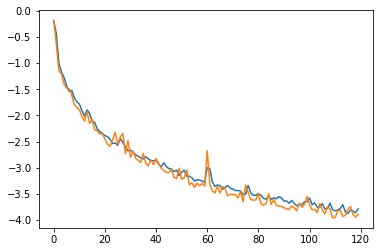

In [197]:
pplot.plot(history_d.history['loss'])
pplot.plot(history_d.history['val_loss'])

In [198]:
adv_model = Model(inputs = mconv_adv.input, outputs=  all_outputs[1])
t = np.linspace(0,1.5,75)
def eval_model_batched(model_, data_in = X_target_experiments, data_out = yrem_norm_target):
    
    batch_size = 100;
    r = []
    nll_target_vals = []

    for batch_start in range(0, data_in.shape[0], batch_size):
        batch_end = batch_start + batch_size
        actual_vals = data_out[batch_start:batch_end][:,np.newaxis].T;

        p = model_(data_in[batch_start:batch_end]);
        r.append(p.prob(t).numpy())
        nll_target_vals.append(-p.log_prob(actual_vals.T).numpy())
        #nll_target_vals.append(p.prob(actual_vals.T).numpy())

    r = np.vstack(r).T
    nll_target_vals = np.vstack(nll_target_vals);
    return r, nll_target_vals

adv_results = eval_model_batched(adv_model)
noadv_results = eval_model_batched(gamma_model)

#x_train.shape

In [199]:
adv_results_source = eval_model_batched(adv_model, data_in = X_source_experiments,data_out= yrem_norm_source)
noadv_results_source = eval_model_batched(gamma_model, data_in = X_source_experiments,data_out= yrem_norm_source)


In [200]:
#pplot.plot(loglik_vals)
print("Expected NLL Results with adv: %f, %f"%(np.mean(adv_results[1]),np.mean(noadv_results[1])))


Expected NLL Results with adv: 14.642763, 14.831947


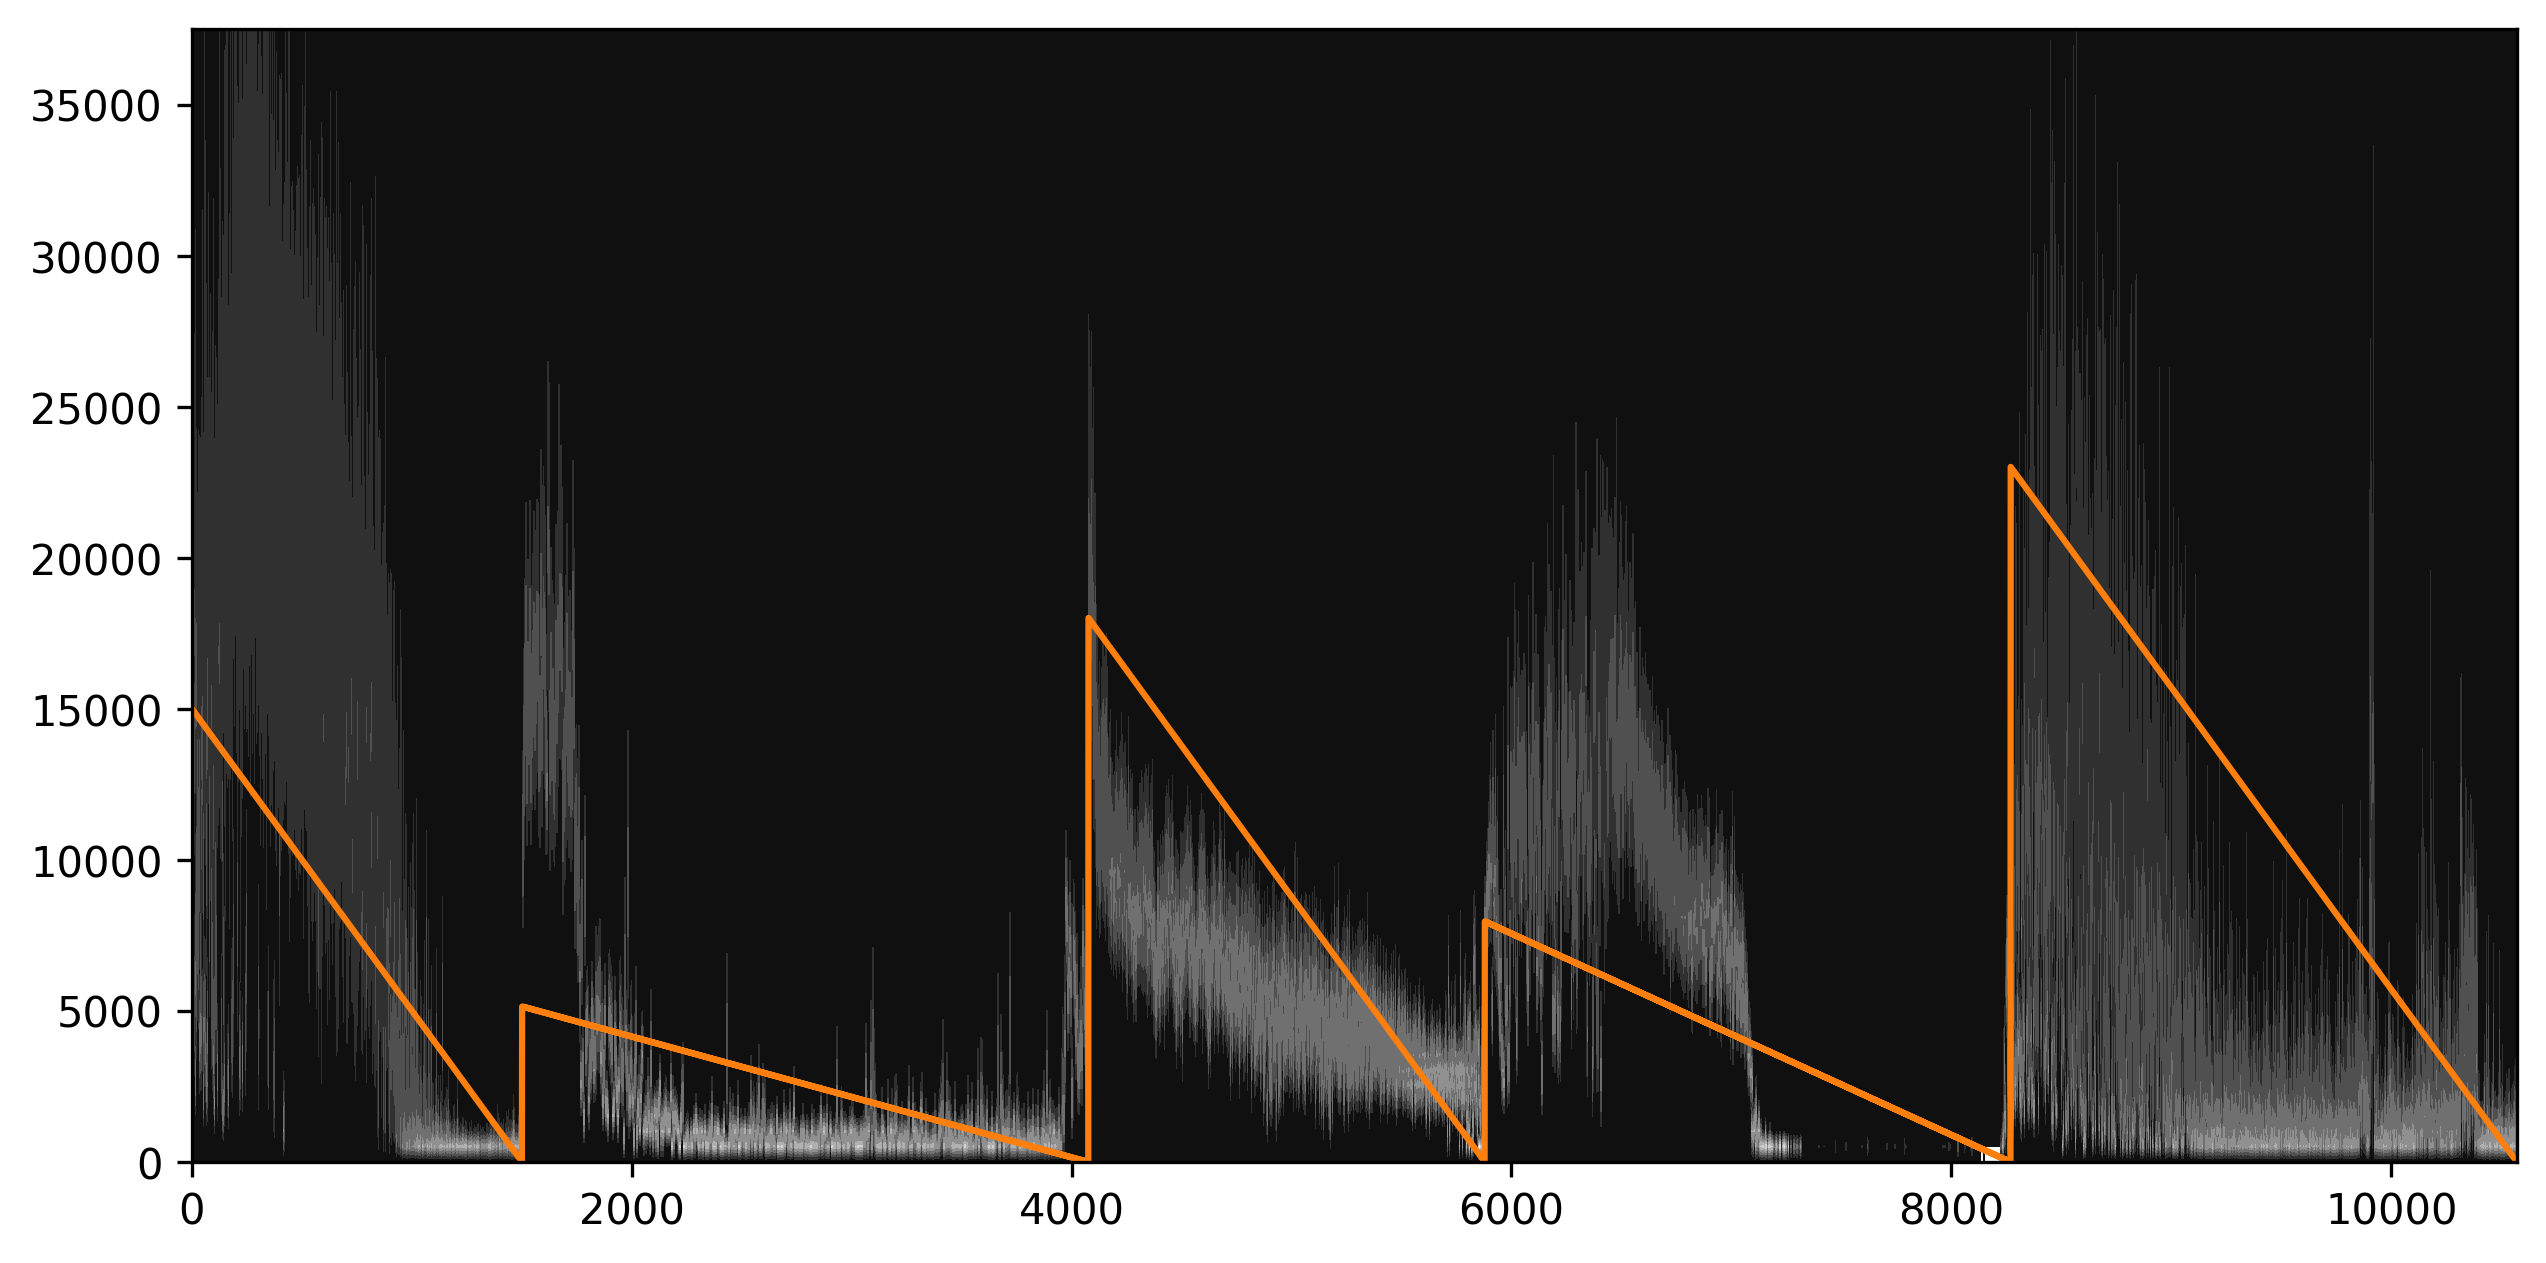

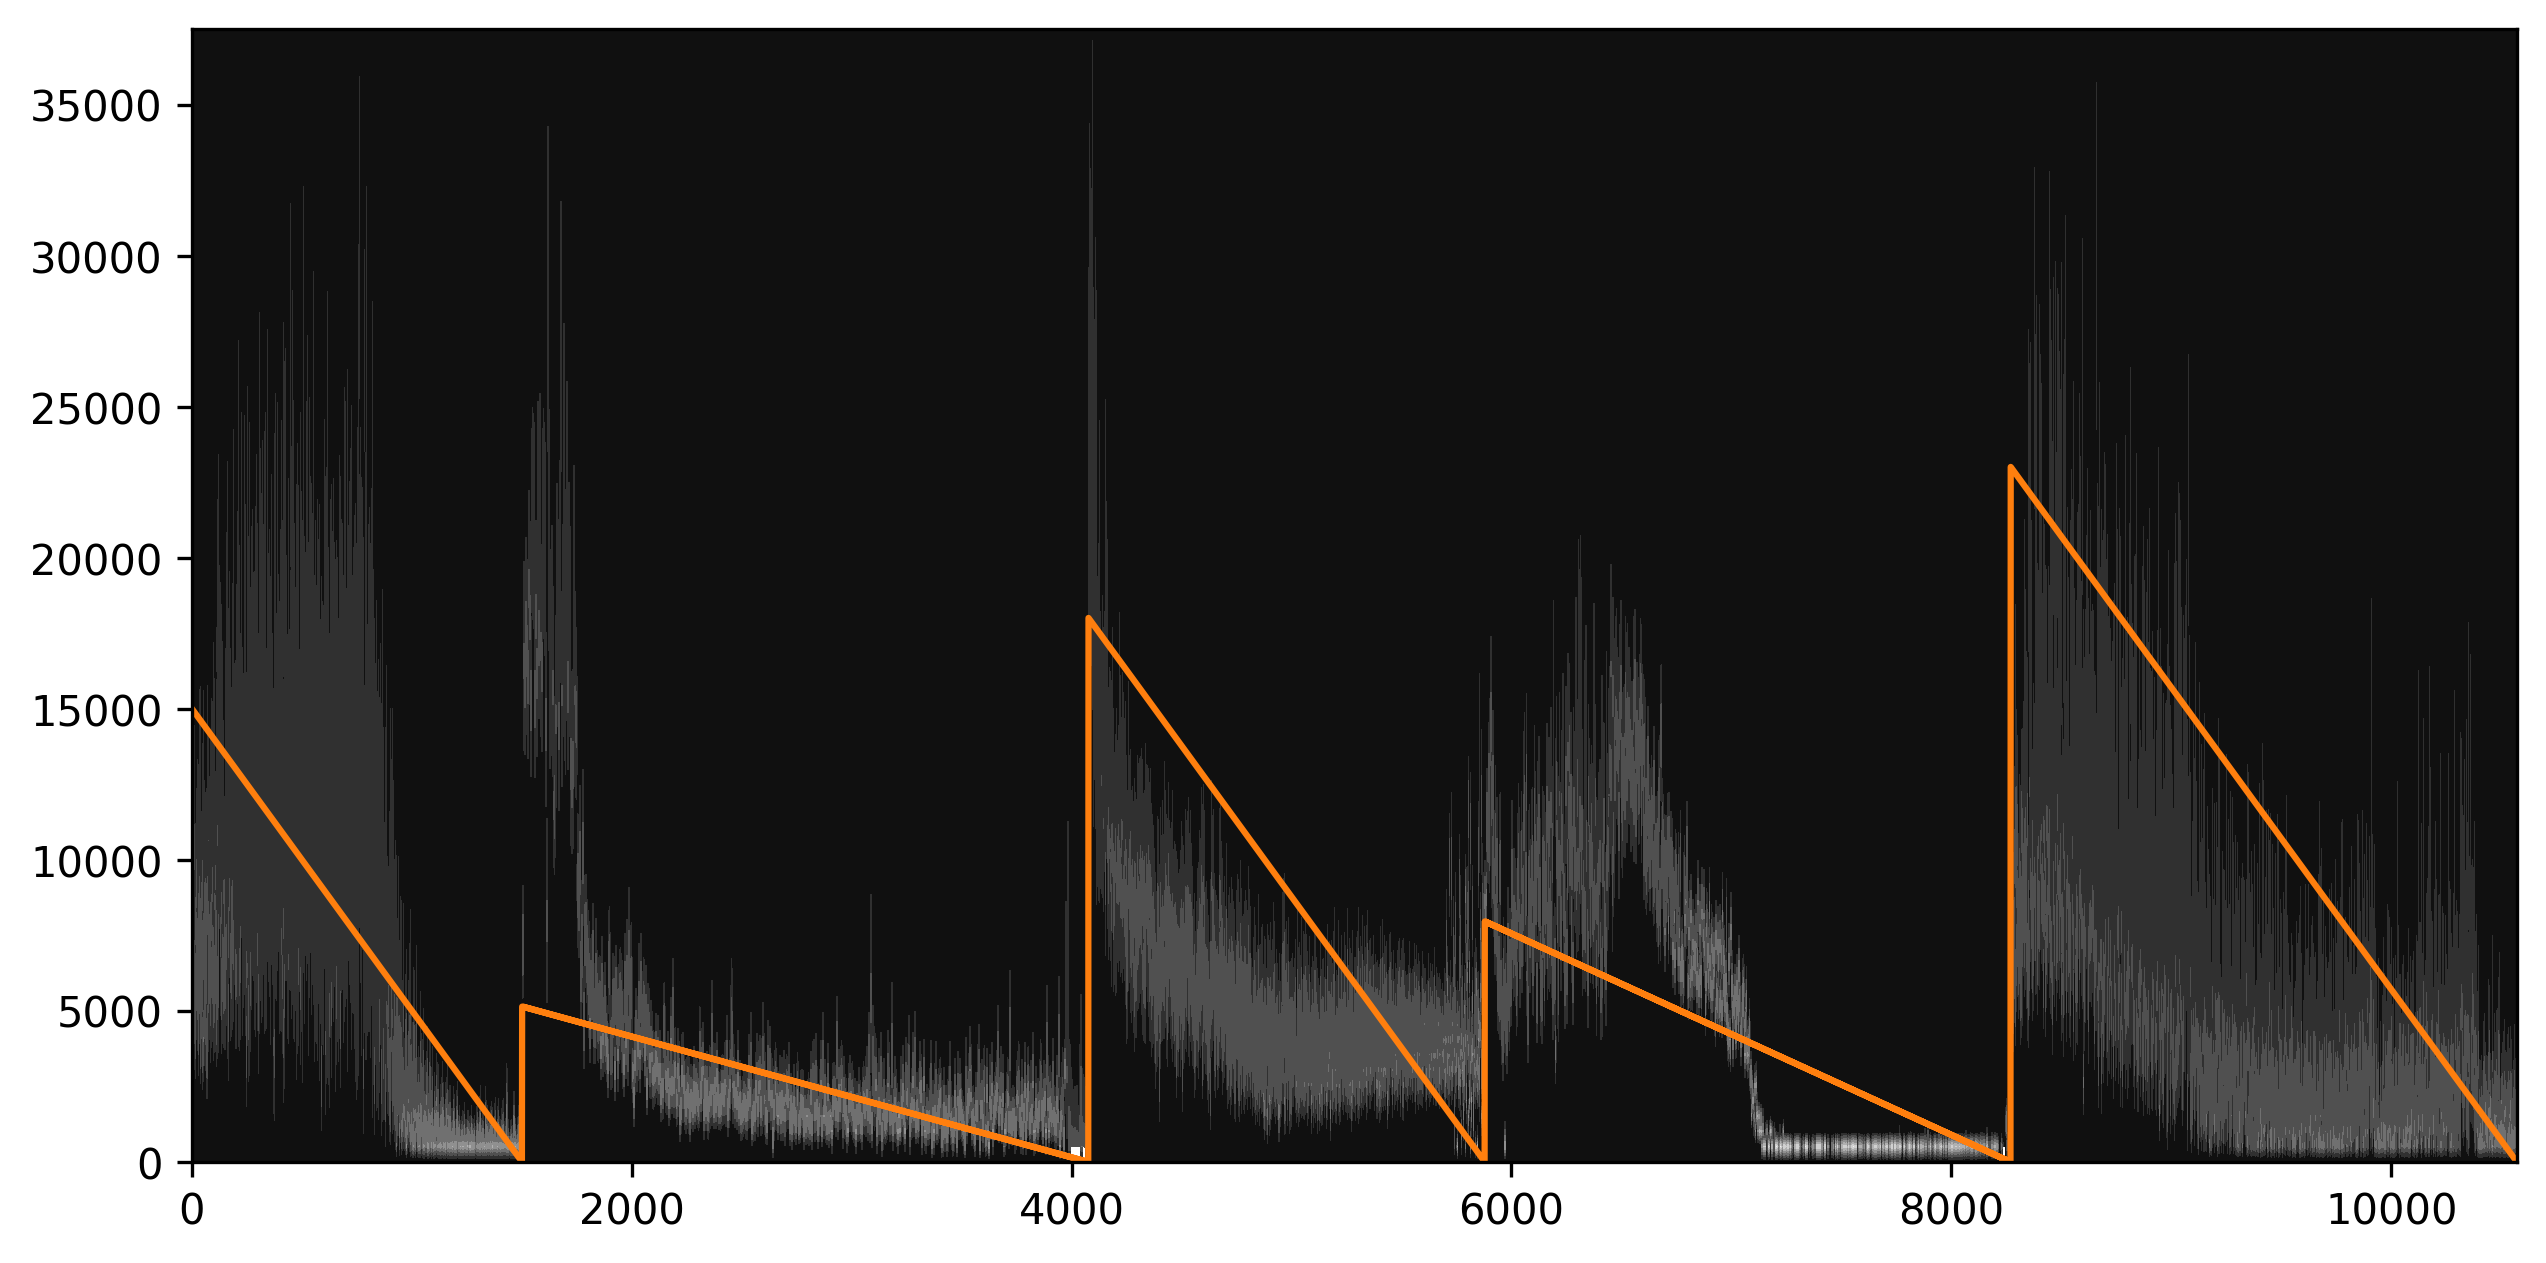

In [201]:
pplot.figure(figsize = (10,5), dpi = 300);
pplot.contourf(range(adv_results[0].shape[1]), t*normalization_factor_time, adv_results[0]**0.4, cmap = "gray")
pplot.plot(range(adv_results[0].shape[1]), yrem_norm_target*normalization_factor_time,'C1')
pplot.show()
pplot.figure(figsize = (10,5), dpi = 300);
pplot.contourf(range(adv_results[0].shape[1]), t*normalization_factor_time, noadv_results[0]**0.4, cmap = "gray")
pplot.plot(range(adv_results[0].shape[1]), yrem_norm_target*normalization_factor_time,'C1')

#pplot.plot(y)
#batch_start,batch_end

In [32]:
# compute expected likelihood on output dataset:
all_loss_functions[1]

<function __main__.<lambda>(y_, py_)>

![alt-text](gamma_distr_out_predictions_noadv_morex.png)


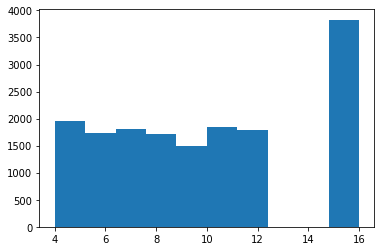

(array([9223.,    0.,    0.,    0.,    0., 5098.,    0.,    0.,    0.,
        1848.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

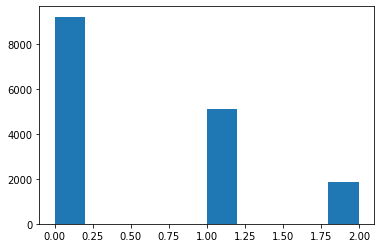

In [107]:
pplot.hist(np.argmax(d_train,1))
pplot.show()
pplot.hist(np.argmax(c_train,1))


In [97]:
test_in['timeseries_input'].shape

(5390, 2559, 2)

In [99]:
test_out.keys()

dict_keys(['P_y_C_d_critic', 'P_y_C_d_predictor', 'P_d_C_y_critic', 'P_d_C_y_predictor', 'P_y_C_l_critic', 'P_y_C_l_predictor', 'P_l_C_y_critic', 'P_l_C_y_predictor', 'P_d_C_l_critic', 'P_d_C_l_predictor', 'P_l_C_d_critic', 'P_l_C_d_predictor'])

In [100]:
loss_fcn

OrderedDict([('P_y_C_d_critic', <function __main__.<lambda>(y, yhat)>),
             ('P_y_C_d_predictor', <function __main__.<lambda>(y_, py_)>),
             ('P_d_C_y_critic', <function __main__.<lambda>(y_, py_)>),
             ('P_d_C_y_predictor', <function __main__.<lambda>(y, yhat)>),
             ('P_y_C_l_critic', <function __main__.<lambda>(y, yhat)>),
             ('P_y_C_l_predictor', <function __main__.<lambda>(y_, py_)>),
             ('P_l_C_y_critic', <function __main__.<lambda>(y_, py_)>),
             ('P_l_C_y_predictor', <function __main__.<lambda>(y, yhat)>),
             ('P_d_C_l_critic', <function __main__.<lambda>(y, yhat)>),
             ('P_d_C_l_predictor', <function __main__.<lambda>(y, yhat)>),
             ('P_l_C_d_critic', <function __main__.<lambda>(y, yhat)>),
             ('P_l_C_d_predictor', <function __main__.<lambda>(y, yhat)>)])

In [336]:
#def eval_sequential_gamma_model(nstates):
#gamma_model(X_source_experiments[0:10])
#gamma_model.summary()

# A simple GraphNet for prediction using sequential data:
# Prediction from sequences can be modeled as a graph where only the last edge has a loss function.
# An arbitrary number of edges can be used 




TensorShape([2, 10, 3])

# Mini-GraphNets
A simple implementation of GraphNets in tensorflow.

In [345]:
n_mlp = 10;
n_edge_state = 15;
n_node_state = 17;

def make_edge_function():
    edge_state_in = Input(shape = (n_edge_state), name = "edge_state");
    node_state_sender_in = Input(shape = (n_node_state), name = "node_sender");
    node_state_receiver_in = Input(shape = (n_node_state), name = "node_receiver");

    ## Building the edge MLP:
    edge_out = keras.layers.concatenate([edge_state_in, node_state_sender_in, node_state_receiver_in])
    
    edge_out = Dense(100, activation = "sigmoid")(edge_out)
    edge_out = Dense(n_edge_state, activation = None)(edge_out)
    
    edge_mlp = Model(inputs = [edge_state_in, node_state_sender_in, node_state_receiver_in ] ,outputs = edge_out)
    
    return edge_mlp

def per_node_edge_aggregator(node_incoming_edges):
    """
    This seems to get the pure edge state.
    I can pass the node state in the edge 
    state if I want to have this as well.
    """
    val  = tf.reduce_mean(tf.stack(node_incoming_edges),0)
    return val

def make_node_function():
    agg_edge_state_in = Input(shape = (n_edge_state), name = "edge_state_agg");
    node_prev_state = Input(shape = (n_node_state), name = "node_sender");

    ## Building the edge MLP:
    node_out = keras.layers.concatenate([agg_edge_state_in, node_prev_state]);
    
    node_out = Dense(100, activation = "sigmoid")(node_out)
    node_out = Dense(n_node_state, activation = None)(node_out)
    
    node_out_model = Model(inputs = [agg_edge_state_in, node_prev_state] ,outputs = node_out)
    return node_out_model

edge_mlp = make_edge_function()
edge_mlp([vv.astype("float32") for vv in [np.random.randn(10,n_edge_state), np.random.randn(10,n_node_state), np.random.randn(10,n_node_state)]])

node_mlp = make_node_function()
node_mlp([vv.astype("float32") for vv in [np.random.randn(10,n_edge_state), np.random.randn(10,n_node_state)]])

class Node:
    def __init__(self, node_attr_tensor):
        self.node_attr_tensor = node_attr_tensor
        self.incoming_edges = [];
        
    def get_state(self):
        return self.node_attr_tensor

class Edge:
    def __init__(self, edge_attr_tensor, node_from, node_to):
        self.edge_tensor = edge_attr_tensor
        self.node_from = node_from
        self.node_to = node_to
        
        # Keep a reference to this edge since it is needed for aggregation afterwards.
        node_to.incoming_edges.append(self)
        
class Graph:
    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges
        
class GraphNet:
    """
    Input is a graph and output is a graph.
    """
    def __init__(self, edge_function, node_function, edge_aggregation_function):
        self.edge_function             = edge_function
        self.node_function             = node_function
        self.edge_aggregation_function = edge_aggregation_function
        
    def graph_eval(self, graph):
        # Evaluate all edge functions:
        self.eval_edge_functions(graph)
        
        # Aggregate edges per node:
        for n in graph.nodes:
            if len(n.incoming_edges) is not 0:
                edge_to_node_agg = self.edge_aggregation_function([e.edge_tensor for e in n.incoming_edges])
                n.node_attr_tensor = self.node_function([edge_to_node_agg, n.node_attr_tensor])
        
        return 
                
    def eval_edge_functions(self,graph):
        """
        Evaluate all edge functions
        """
        for edge in graph.edges:
            edge.edge_tensor = self.edge_function([edge.edge_tensor, edge.node_from.node_attr_tensor, edge.node_to.node_attr_tensor])
            
        

In [347]:
n1 = Node(tf.Variable(np.random.randn(10,n_node_state).astype("float32")))
n2 = Node(tf.Variable(np.random.randn(10,n_node_state).astype("float32")))
e1 = Edge(np.zeros([10,n_edge_state]).astype("float32"), n1,n2)
        
g = Graph(nodes = [n1,n2], edges = [e1])
gn = GraphNet(edge_function = edge_mlp, node_function = node_mlp, edge_aggregation_function = per_node_edge_aggregator)
gn.graph_eval(g)
print(n2.node_attr_tensor[0])
gn.graph_eval(g)
print(n2.node_attr_tensor[0])
    

tf.Tensor(
[ 0.41832855  0.18835607  0.3912712  -0.06191619 -0.7263874   0.38435724
 -0.3455946  -0.41121125  0.86421436 -0.8500655   0.48130178  0.27495554
  0.38713956  0.38639674  0.34935838 -0.06566793  0.5967278 ], shape=(17,), dtype=float32)
tf.Tensor(
[ 0.5468834   0.2990827   0.48607638  0.16257733 -0.54706067  0.33029777
 -0.29881042 -0.2342881   0.754018   -0.8874005   0.35750324 -0.02003047
  0.4953017   0.40786168  0.3928435  -0.1948385   0.7901766 ], shape=(17,), dtype=float32)


In [321]:
#gn.edge_function([np.random.randn(10,n_edge_state), np.random.randn(10,n_node_state), np.random.randn(10,n_node_state)])
print(e1)
e1.edge_tensor.shape
e1.node_from.node_attr_tensor.shape, n_node_state
gn.edge_function([e1.edge_tensor, e1.node_from.node_attr_tensor, e1.node_from.node_attr_tensor])



<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[-0.95893955,  0.5616526 , -0.2530312 ,  0.06968968,  0.15343323,
         0.9750211 ,  0.58112806,  0.33133668,  0.33467057,  0.3010056 ,
         0.10168518, -0.5706796 , -0.72425723,  0.66489375,  0.42992464]],
      dtype=float32)>

In [349]:
#def experiment_to_graph_data(time_differences, eid):




(23543, 2559, 2)